# <div align="center"> Assignment 2 </div>

###  <div align="center"> Sumeth Lokuliyana (s3904996) </div>
###  <div align="center"> Janak Datta Velagapudi (s3903576) </div>

## <div align="center"> Classify Images based on Cancerous cells or not  </div>







### * As for this section we will be predicting images of cancer cells if they are cancerous or not .

### Import required packages 

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import RMSprop ,Adadelta ,SGD ,Adamax
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall, AUC 
from sklearn.metrics import confusion_matrix

### Reading the CSV file and the images into a DataFrame .

##### The images are first read using the cv2 read and then appends it to an array . Similarly we add the image path to the dataframe as well.

In [2]:
main_csv_file = "data_labels_mainData.csv"
extra_csv_file ="data_labels_extraData.csv"
df = pd.read_csv(main_csv_file)
extra_df = pd.read_csv(extra_csv_file)

# Read the images from the directory and convert them to arrays
image_dir = "patch_images"
image_arrays = []
image_path=[]
for image_name in df["ImageName"]:
    img_pth = image_dir + "/" + image_name
    image_path.append(img_pth)
    img = cv2.imread(os.path.join(image_dir, image_name))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    image_arrays.append(img)
image_arrays = np.array(image_arrays)

#Merge the image arrays with the CSV dataframe
df["image_data"] = list(image_arrays)
df["image_path"] = image_path
df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_data,image_path
0,22405,1,22405.png,fibroblast,0,0,"[[[237, 213, 242], [234, 210, 239], [231, 206,...",patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,"[[[211, 175, 221], [211, 175, 223], [216, 180,...",patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,"[[[247, 243, 247], [246, 242, 248], [245, 240,...",patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,"[[[242, 242, 243], [241, 241, 243], [241, 241,...",patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,"[[[189, 130, 189], [185, 127, 187], [183, 126,...",patch_images/22409.png
...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,"[[[180, 138, 171], [217, 175, 206], [244, 209,...",patch_images/1625.png
9892,1626,60,1626.png,epithelial,2,1,"[[[228, 173, 212], [212, 151, 191], [192, 132,...",patch_images/1626.png
9893,1627,60,1627.png,epithelial,2,1,"[[[193, 141, 175], [205, 162, 191], [217, 180,...",patch_images/1627.png
9894,1628,60,1628.png,epithelial,2,1,"[[[232, 202, 227], [202, 159, 188], [195, 146,...",patch_images/1628.png


### Splitting the data into train and test sets


##### Initially we create a df of features that has the cellTypeName , celltype ,  the image data and the image path . We also create a df for the target variable Y which is "isCancerous" contains 1 or 0 if the image is cancerous or not. 

In [3]:

df = df.drop("ImageName", axis=1)
df = df.drop("InstanceID",axis=1)
df = df.drop("patientID",axis=1)
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_test, test_size=0.2, random_state=42)
display(df)

,cellTypeName,cellType,isCancerous,image_data,image_path
0,fibroblast,0,0,"[[[237, 213, 242], [234, 210, 239], [231, 206,...",patch_images/22405.png
1,fibroblast,0,0,"[[[211, 175, 221], [211, 175, 223], [216, 180,...",patch_images/22406.png
2,fibroblast,0,0,"[[[247, 243, 247], [246, 242, 248], [245, 240,...",patch_images/22407.png
3,fibroblast,0,0,"[[[242, 242, 243], [241, 241, 243], [241, 241,...",patch_images/22408.png
4,fibroblast,0,0,"[[[189, 130, 189], [185, 127, 187], [183, 126,...",patch_images/22409.png
...,...,...,...,...,...
9891,epithelial,2,1,"[[[180, 138, 171], [217, 175, 206], [244, 209,...",patch_images/1625.png
9892,epithelial,2,1,"[[[228, 173, 212], [212, 151, 191], [192, 132,...",patch_images/1626.png
9893,epithelial,2,1,"[[[193, 141, 175], [205, 162, 191], [217, 180,...",patch_images/1627.png
9894,epithelial,2,1,"[[[232, 202, 227], [202, 159, 188], [195, 146,...",patch_images/1628.png


#### We will now check the distribution of cancerous and non cancerous cells 
##### From the graph below we can say that there are more non-cancerous cells.

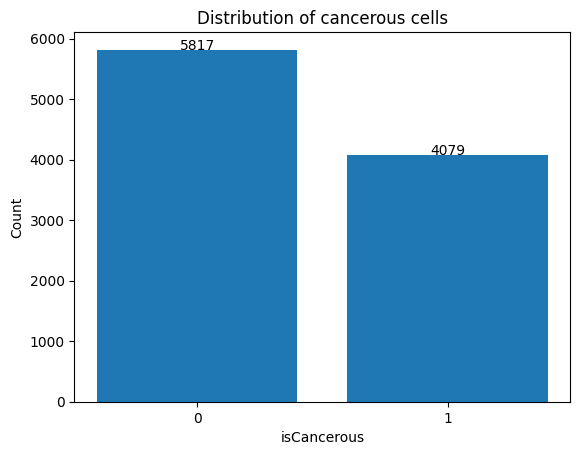

In [4]:


target_counts = df["isCancerous"].value_counts()
plt.bar([0,1], target_counts.values)
plt.xticks([0,1])
plt.title('Distribution of cancerous cells')
plt.xlabel('isCancerous')
plt.ylabel('Count')
for i, value in enumerate(target_counts.values):
    plt.text(i, value, str(value), ha='center')
plt.show()


We will plot a graph to figure out which type of cells are more prone to become cancerous

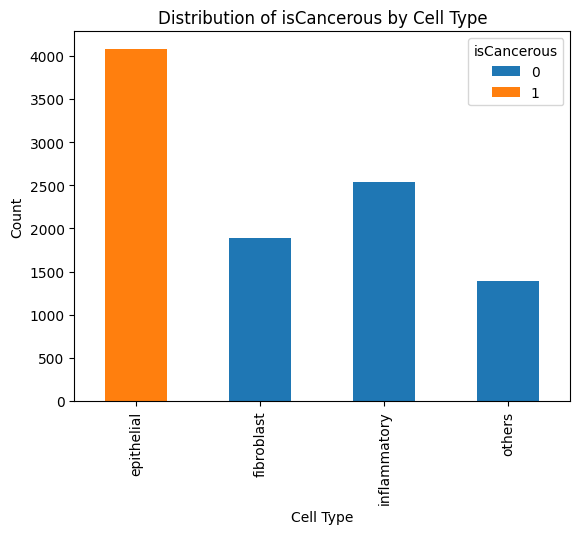

In [5]:
grouped = df.groupby(['isCancerous', 'cellTypeName'])['cellTypeName'].count().unstack('isCancerous')
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Distribution of isCancerous by Cell Type')
plt.show()


We will print out some random images to visualize

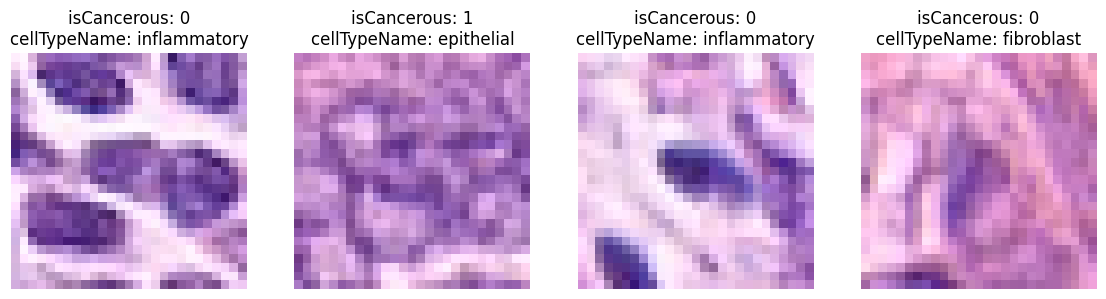

In [6]:
r_inx = np.random.choice(9896, 4)
rand_data = df.loc[r_inx,['image_path', 'isCancerous', 'cellTypeName']]

plt.figure(figsize=(14,4))
for i, (image_path, is_cancerous, cell_type) in enumerate(zip(rand_data['image_path'], rand_data['isCancerous'], rand_data['cellTypeName'])):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im)
    plt.title(f'isCancerous: {is_cancerous}\ncellTypeName: {cell_type}')
    plt.axis('off')
    
plt.show()


##  The Base Model

For the base model well use just three layers , we will increment improvements on this model to gain a better accurcy and lower margin between the train and test data.
We will implement 
+ The flatten layer - this will flatten the input image from a 3D shape (32x32x3) into a 1D array of 3072 elements.
+ The Dense layer It consists of 256 neurons which mean every neuron is connected every neuron in the previous layer.It uses sigmoid as the activation fucntion.
+ The Dense layer This is the last output layer, which has 2 neurons and it determines if an input picture is cancerous or not. It uses the sigmoid activation   function, which produces a value between 0 and 1 for each neuron, indicating the probability that the input picture belongs to that classification.

In [7]:
base_model = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(256, activation='sigmoid'),
    Dense(1 , activation='sigmoid')
])

In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 786,945
Trainable params: 786,945
Non-trainable params: 0
_________________________________________________________________


+ optimizer='sgd' -Stochastic gradient descent (SGD) is a popular optimization approach used for changing the neural network's weights and biases throughout the training period.
+ loss=binary_crossentropy - This is used beacuse the classification is between two classes (isCancerous or not)
+ metrics=['accuracy'] - gives us the percentage of correctly predicted labels out of the total number of predictions made.

We then convert the integer values to string because the ImageDataGenerator takes in string values

In [9]:
from keras.losses import binary_crossentropy
base_model.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=['accuracy'])


X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')

X_train['cellType'] = X_train['cellType'].astype('str')
X_val['cellType'] = X_val['cellType'].astype('str')

## Setting up ImageDataGenerators 

+ The image generators will rescale the images pixel values by dividing them by 255
+ The target_size argument determines the size to which the photos will be downsized/upsized in this case we upsize it
+ The batch_size parameter provides the number of images to include in each batch during training and validation
+ The class_mode parameter tells if  the labels are binary or not.

### Fitting the data given by the ImageDataGenerators to the base_model

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')


validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_val,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')   

base_history = base_model.fit(train_generator, validation_data = validation_generator, epochs=200, verbose=1)

Found 1584 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Epoch 1/200
50/50 [==============================] - 1s 21ms/step - loss: 0.6466 - accuracy: 0.6162 - val_loss: 0.6537 - val_accuracy: 0.5758
Epoch 2/200
50/50 [==============================] - 1s 18ms/step - loss: 0.6291 - accuracy: 0.6282 - val_loss: 0.6377 - val_accuracy: 0.5758
Epoch 3/200
50/50 [==============================] - 1s 20ms/step - loss: 0.6083 - accuracy: 0.6540 - val_loss: 0.6053 - val_accuracy: 0.6288
Epoch 4/200
50/50 [==============================] - 1s 18ms/step - loss: 0.5936 - accuracy: 0.6837 - val_loss: 0.5991 - val_accuracy: 0.6187
Epoch 5/200
50/50 [==============================] - 1s 22ms/step - loss: 0.5781 - accuracy: 0.7090 - val_loss: 0.5760 - val_accuracy: 0.6641
Epoch 6/200
50/50 [==============================] - 1s 17ms/step - loss: 0.5642 - accuracy: 0.7304 - val_loss: 0.5719 - val_accuracy: 0.6364
Epoch 7/200
50/50 [========

## Graphs of Accuracy and Loss on Train and Validation data

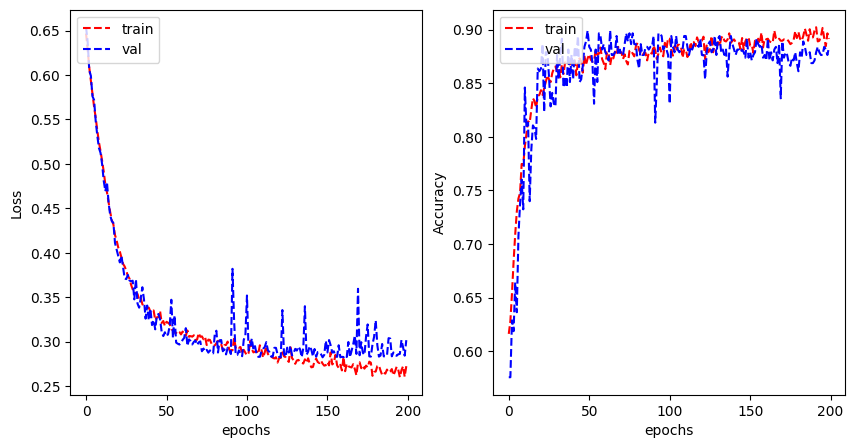

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(base_history.history['loss'], 'r--')
plt.plot(base_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(base_history.history['accuracy'], 'r--')
plt.plot(base_history.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Regularization of the model 

This is done inorder to reduce the overfitting of the data as the validation accuracy is less than that of the training accuracy .

In [12]:
reg_lambda = 0.0001
from keras.regularizers import l2 ,l1

base_model_reg = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(128, activation='sigmoid', kernel_regularizer=l2(reg_lambda)),
    Dense(1,activation='sigmoid', kernel_regularizer=l2(reg_lambda))
])

base_model_reg.compile(optimizer=SGD(),
              loss=binary_crossentropy,
              metrics=['accuracy'])

history_reg = base_model_reg.fit(train_generator, validation_data = validation_generator, epochs=200, verbose=1)

Epoch 1/200
50/50 [==============================] - 1s 16ms/step - loss: 0.6830 - accuracy: 0.6111 - val_loss: 0.6699 - val_accuracy: 0.5960
Epoch 2/200
50/50 [==============================] - 1s 14ms/step - loss: 0.6526 - accuracy: 0.6301 - val_loss: 0.6578 - val_accuracy: 0.5985
Epoch 3/200
50/50 [==============================] - 1s 15ms/step - loss: 0.6379 - accuracy: 0.6509 - val_loss: 0.6375 - val_accuracy: 0.6843
Epoch 4/200
50/50 [==============================] - 1s 15ms/step - loss: 0.6231 - accuracy: 0.6761 - val_loss: 0.6336 - val_accuracy: 0.6212
Epoch 5/200
50/50 [==============================] - 1s 14ms/step - loss: 0.6081 - accuracy: 0.6913 - val_loss: 0.6081 - val_accuracy: 0.6894
Epoch 6/200
50/50 [==============================] - 1s 14ms/step - loss: 0.5951 - accuracy: 0.7109 - val_loss: 0.6011 - val_accuracy: 0.6591
Epoch 7/200
50/50 [==============================] - 1s 15ms/step - loss: 0.5826 - accuracy: 0.7260 - val_loss: 0.5808 - val_accuracy: 0.8005
Epoch 

## Graphs of Accuracy and Loss on Train and Validation data(regularized models)

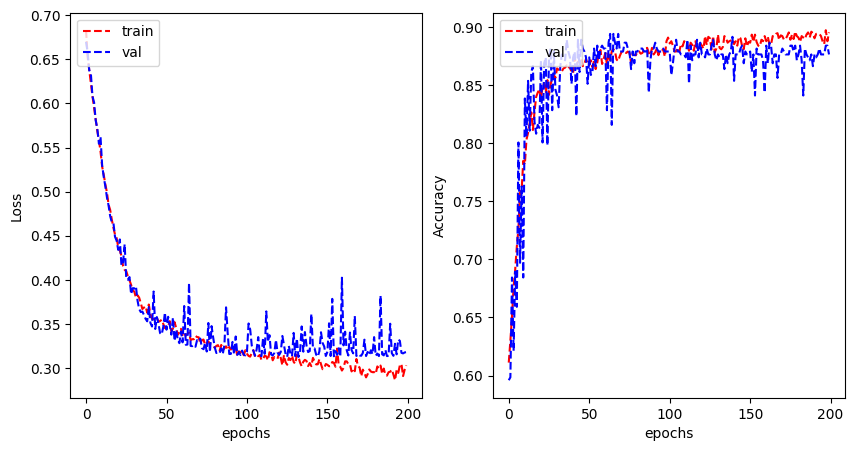

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['accuracy'], 'r--')
plt.plot(history_reg.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

- We can see that the 

### To reduce overfitting even further we will be using Dropout


In [14]:
base_model_reg_drp = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(256, activation='sigmoid'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

base_model_reg_drp.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=['accuracy'])

history_reg_drp = base_model_reg_drp.fit(train_generator, validation_data = validation_generator, epochs=200, verbose=1)

Epoch 1/200
50/50 [==============================] - 1s 19ms/step - loss: 0.7981 - accuracy: 0.5537 - val_loss: 0.7036 - val_accuracy: 0.4242
Epoch 2/200
50/50 [==============================] - 1s 17ms/step - loss: 0.7142 - accuracy: 0.5745 - val_loss: 0.6627 - val_accuracy: 0.5758
Epoch 3/200
50/50 [==============================] - 1s 16ms/step - loss: 0.7018 - accuracy: 0.5688 - val_loss: 0.6281 - val_accuracy: 0.5758
Epoch 4/200
50/50 [==============================] - 1s 17ms/step - loss: 0.6510 - accuracy: 0.6332 - val_loss: 0.6249 - val_accuracy: 0.5758
Epoch 5/200
50/50 [==============================] - 1s 17ms/step - loss: 0.6143 - accuracy: 0.6749 - val_loss: 0.5428 - val_accuracy: 0.7096
Epoch 6/200
50/50 [==============================] - 1s 17ms/step - loss: 0.5495 - accuracy: 0.7273 - val_loss: 0.4937 - val_accuracy: 0.8561
Epoch 7/200
50/50 [==============================] - 1s 17ms/step - loss: 0.5019 - accuracy: 0.7626 - val_loss: 0.4225 - val_accuracy: 0.8510
Epoch 

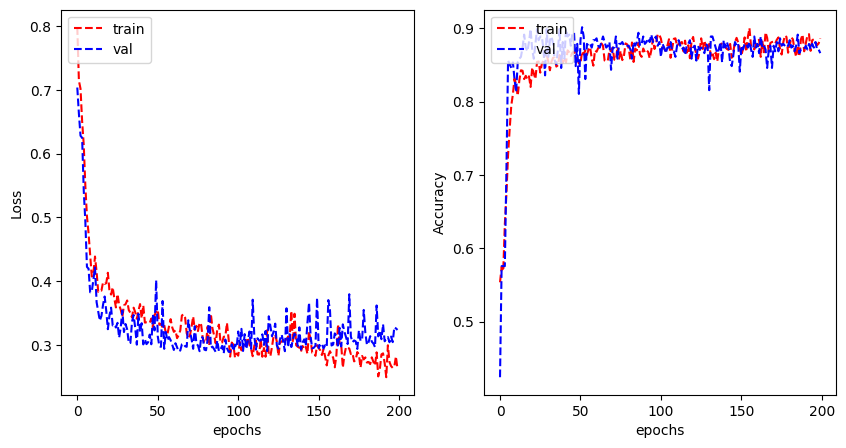

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg_drp.history['loss'], 'r--')
plt.plot(history_reg_drp.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg_drp.history['accuracy'], 'r--')
plt.plot(history_reg_drp.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [16]:
X_test['isCancerous'] = X_test['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=X_test,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')

Found 1980 validated image filenames belonging to 2 classes.


In [17]:
base_model.evaluate(test_generator)
base_model_reg.evaluate(test_generator)
base_model_reg_drp.evaluate(test_generator)

1980/1980 [==============================] - 3s 1ms/step - loss: 0.2609 - accuracy: 0.9081


[0.2609342336654663, 0.9080808162689209]

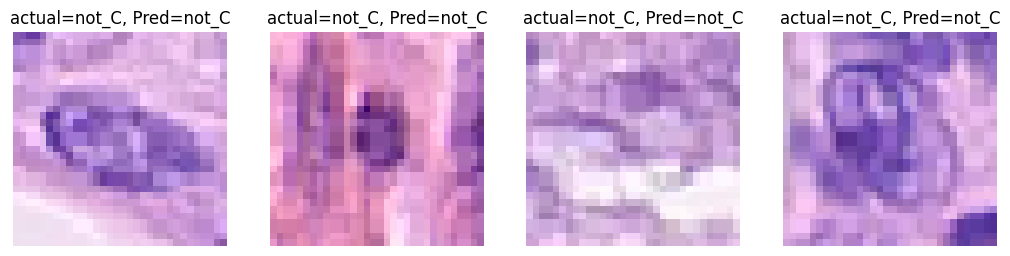

In [18]:
label_names = {'not_C' : 0, 'is_C' : 1}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = base_model_reg_drp.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("actual={}, Pred={}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

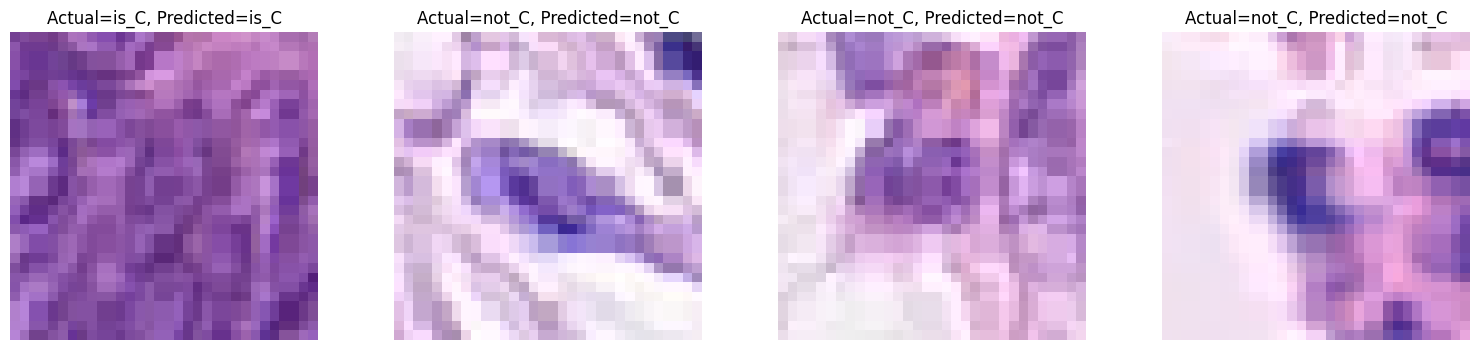

In [19]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model_reg_drp.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


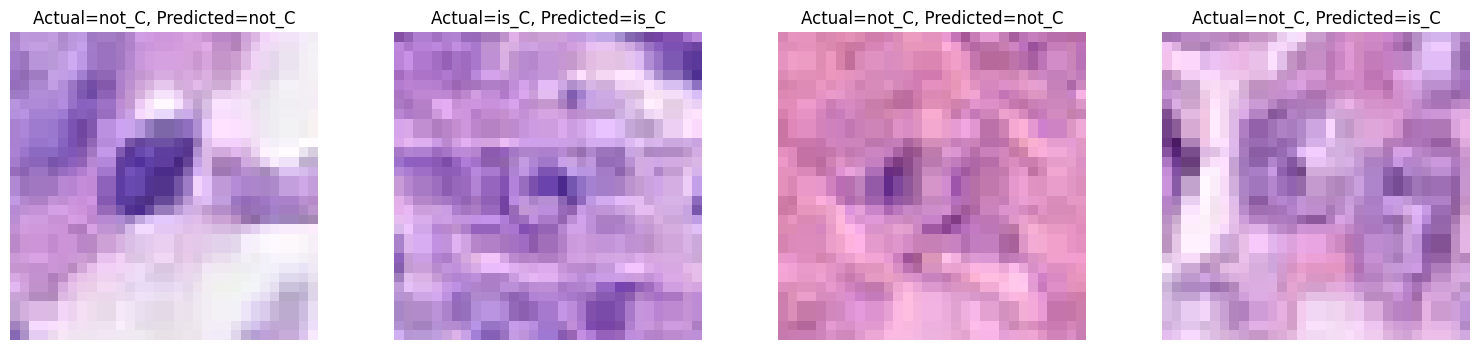

In [20]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model_reg.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


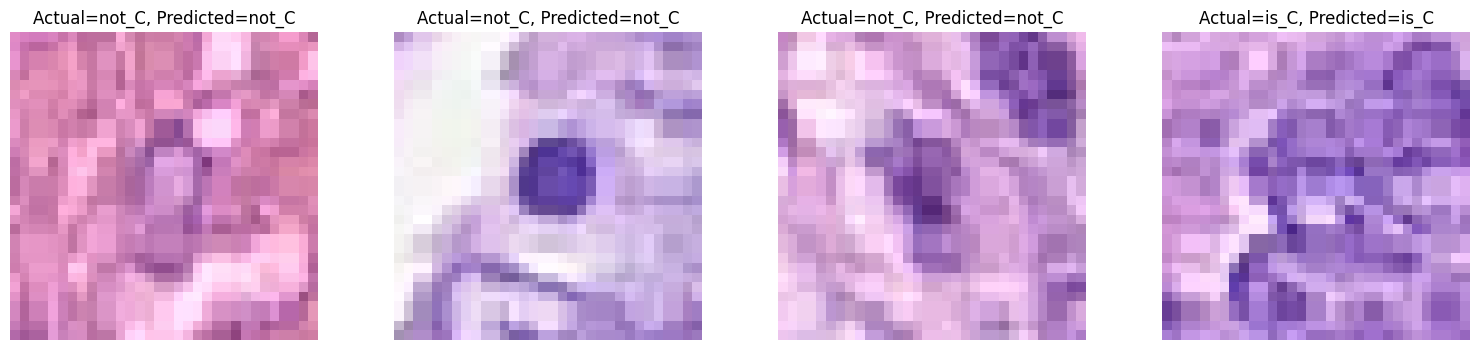

In [21]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


### Adding more layers to the model 

In [22]:
adv_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



adv_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=binary_crossentropy,
              metrics=['accuracy'])

history_adv = adv_model.fit(train_generator, validation_data = validation_generator, epochs=200, verbose=1)

Epoch 1/200
50/50 [==============================] - 4s 61ms/step - loss: 13.0148 - accuracy: 0.5682 - val_loss: 10.6887 - val_accuracy: 0.5758
Epoch 2/200
50/50 [==============================] - 3s 59ms/step - loss: 9.0850 - accuracy: 0.5859 - val_loss: 7.6798 - val_accuracy: 0.5758
Epoch 3/200
50/50 [==============================] - 3s 59ms/step - loss: 6.7194 - accuracy: 0.6067 - val_loss: 5.8427 - val_accuracy: 0.5758
Epoch 4/200
50/50 [==============================] - 3s 55ms/step - loss: 5.2204 - accuracy: 0.6604 - val_loss: 4.6424 - val_accuracy: 0.6591
Epoch 5/200
50/50 [==============================] - 3s 52ms/step - loss: 4.2205 - accuracy: 0.7639 - val_loss: 3.7649 - val_accuracy: 0.8611
Epoch 6/200
50/50 [==============================] - 3s 53ms/step - loss: 3.5114 - accuracy: 0.8409 - val_loss: 3.3416 - val_accuracy: 0.7677
Epoch 7/200
50/50 [==============================] - 3s 58ms/step - loss: 3.0492 - accuracy: 0.8428 - val_loss: 2.8201 - val_accuracy: 0.8485
Epoc

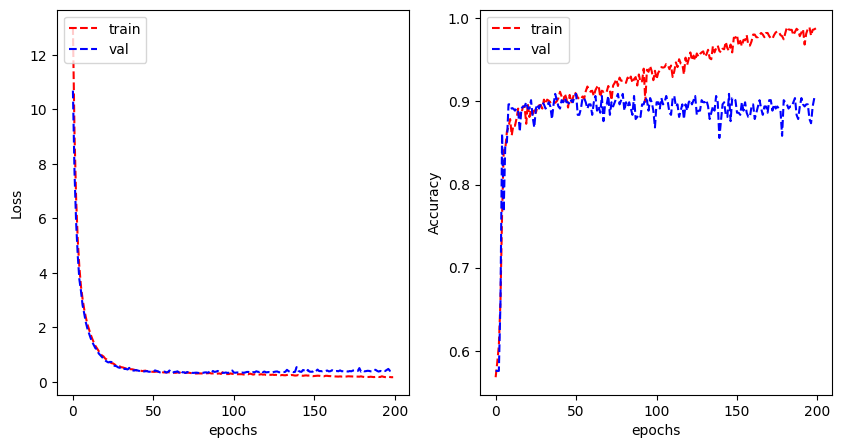

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_adv.history['loss'], 'r--')
plt.plot(history_adv.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_adv.history['accuracy'], 'r--')
plt.plot(history_adv.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [24]:
adv_model.evaluate(test_generator)

1980/1980 [==============================] - 10s 5ms/step - loss: 0.1998 - accuracy: 0.9793


[0.19978539645671844, 0.9792929291725159]

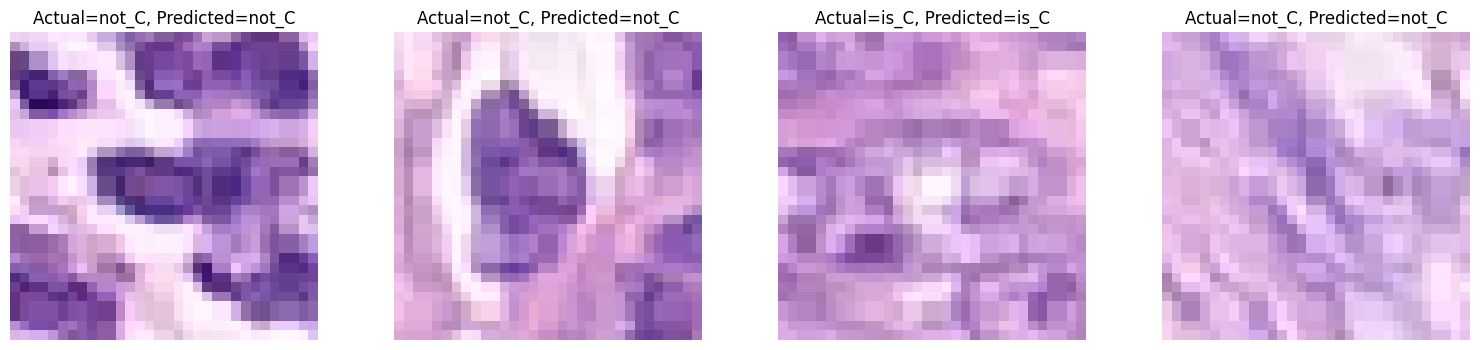

In [25]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred =adv_model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


In [26]:
adv_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=binary_crossentropy,
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_auc = adv_model.evaluate(test_generator)

# Get the predictions for the test set
y_pred = adv_model.predict(test_generator)

# Get the true labels for the test set
y_true = test_generator.classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, np.round(y_pred))

# Print the evaluation metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
print(f'Test AUC-ROC score: {test_auc:.4f}')
print('Confusion matrix:\n', confusion_mtx)


1980/1980 [==============================] - 8s 4ms/step
Test loss: 0.1998
Test accuracy: 0.9793
Test precision: 0.9771
Test recall: 0.9709
Test AUC-ROC score: 0.9944
Confusion matrix:
 [[720 469]
 [474 317]]


In [27]:
image_dir_edf = "patch_images"
image_arrays_edf = []
image_path_edf=[]
for image_name in extra_df["ImageName"]:
    img_pth = image_dir_edf + "/" + image_name
    image_path_edf.append(img_pth)
    img = cv2.imread(os.path.join(image_dir_edf, image_name))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    image_arrays_edf.append(img)
image_arrays_edf = np.array(image_arrays_edf)

#Merge the image arrays with the CSV dataframe
extra_df["image_data"] = list(image_arrays_edf)
extra_df["image_path"] = image_path_edf

In [28]:
extra_df = extra_df.drop("ImageName", axis=1)
extra_df = extra_df.drop("InstanceID",axis=1)
extra_df = extra_df.drop("patientID",axis=1)

In [29]:
extra_df['isCancerous'] = extra_df['isCancerous'].astype('str')

only_C = extra_df[extra_df['isCancerous']== "1"]
only_C

,isCancerous,image_data,image_path
62,1,"[[[186, 109, 157], [184, 107, 156], [188, 113,...",patch_images/12748.png
63,1,"[[[221, 188, 225], [212, 179, 216], [217, 182,...",patch_images/12749.png
64,1,"[[[213, 183, 213], [234, 208, 238], [238, 212,...",patch_images/12750.png
65,1,"[[[217, 165, 211], [215, 174, 216], [211, 175,...",patch_images/12751.png
66,1,"[[[248, 237, 254], [240, 233, 249], [244, 239,...",patch_images/12752.png
...,...,...,...
7800,1,"[[[217, 142, 200], [214, 138, 194], [212, 136,...",patch_images/7667.png
7801,1,"[[[250, 208, 242], [225, 177, 216], [212, 157,...",patch_images/7668.png
7802,1,"[[[213, 127, 165], [199, 112, 156], [187, 99, ...",patch_images/7669.png
7803,1,"[[[243, 228, 242], [241, 227, 239], [240, 228,...",patch_images/7670.png


In [30]:
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
extra_generator = extra_datagen.flow_from_dataframe(
        dataframe=extra_df,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')



Found 10384 validated image filenames belonging to 2 classes.


In [31]:
base_model_reg_drp.evaluate(extra_generator)

10384/10384 [==============================] - 17s 2ms/step - loss: 0.6634 - accuracy: 0.7504


[0.6633853912353516, 0.7503852248191833]

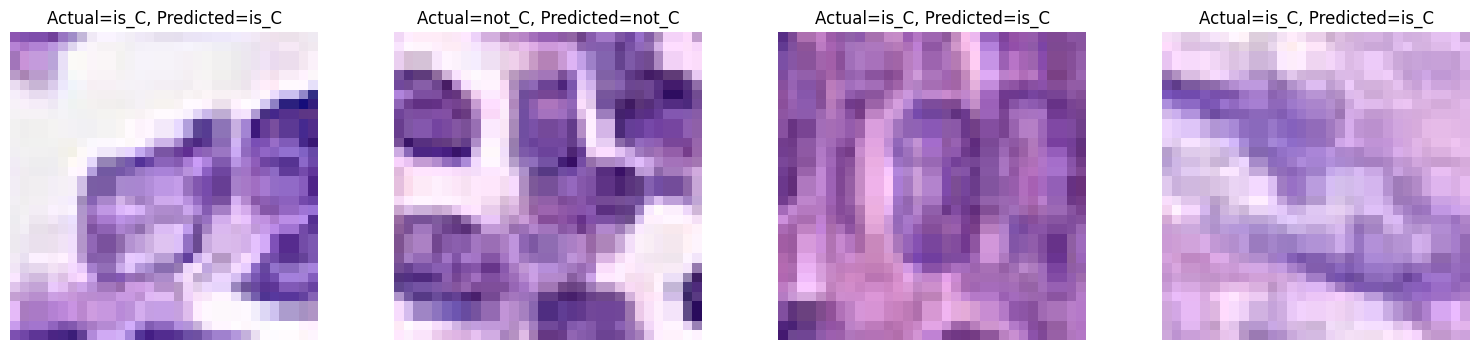

In [32]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model_reg_drp.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()
